In [55]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error


### 3. Load and Prepare Data
Load the dataset and prepare it for the LSTM model. This involves parsing dates, normalizing the 'Page.Loads' data, and creating sequences for the LSTM.

In [56]:
# Load dataset
data = pd.read_csv('data.csv', parse_dates=['Date'], index_col='Date')

# Convert 'Page.Loads' from string to integer
data['Page.Loads'] = data['Page.Loads'].str.replace(',', '').astype(int)

# Drop unnecessary columns
columns_to_drop = ["Row", "Day", "Day.Of.Week", "Unique.Visits", "Returning.Visits", "First.Time.Visits"]
data.drop(columns=columns_to_drop, inplace=True)

# Initialize and fit the MinMaxScaler on the training data only
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data.loc['2019-01-01':'2019-12-31', ['Page.Loads']])

# Display the first few rows of the dataset
print(data.head())


            Page.Loads
Date                  
2014-09-14        2146
2014-09-15        3621
2014-09-16        3698
2014-09-17        3667
2014-09-18        3316


## 4. Function to Normalize Data and Create Sequences

In [57]:
def create_sequences(data, window_size):
    """
    This function creates sequences of `window_size` length and their corresponding labels.
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        sequence = data[i:(i + window_size)]
        label = data[i + window_size]
        X.append(sequence)
        y.append(label)
    return np.array(X), np.array(y)


def prepare_data(data, start_date, end_date, window_size, scaler):
    """
    Normalize data within the start and end date and create LSTM sequences.
    """
    # Filter data for the date range
    data_filtered = data.loc[start_date:end_date, 'Page.Loads'].values.reshape(-1, 1)
    
    # Normalize data using the provided scaler
    data_normalized = scaler.transform(data_filtered)
    
    # Create sequences
    X, y = create_sequences(data_normalized, window_size)
    X = X.reshape((X.shape[0], window_size, 1))
    
    return X, y


## Step 6: Build and Train LSTM Model

In [58]:
def train_model(X_train, y_train, window_size):
    """
    This function builds and trains the LSTM model.
    """
    # Build LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(window_size, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
    return model


## Step 7: Evaluate Model and Plot Results

In [59]:
def plot_predictions(test, y_test, predicted_test, start_date, end_date, window_size, date_time):
    """
    This function plots the actual versus predicted page loads, with a style similar to Prophet's plots.
    """
    # Ensure the test dates are correctly aligned with the length of y_test and predicted_test
    test_dates = test[start_date:end_date].index[window_size:]  # Adjusting the test_dates to match y_test and predicted_test
    
    # Calculate uncertainty (dummy example: 10% of predictions)
    uncertainty = 0.10 * predicted_test.flatten()
    
    # Plot actual vs predicted for the test set
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot actual values
    ax.scatter(test_dates, y_test, color='red', label='Actual')
    
    # Plot predicted values
    ax.plot(test_dates, predicted_test, color='blue', label='Predicted')
    
    # Add a shaded region to represent uncertainty
    ax.fill_between(test_dates, 
                    (predicted_test.flatten() - uncertainty), 
                    (predicted_test.flatten() + uncertainty), 
                    color='blue', alpha=0.2)
    
    # Set the title and labels
    ax.set_title( 'LSTM Page Load Time Prediction with ' + date_time + ' of training data')
    ax.set_xlabel('Date')
    ax.set_ylabel('Page Loads')
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Set x-axis and y-axis limits
    ax.set_xlim([pd.Timestamp(start_date), pd.Timestamp(end_date)])
    ax.set_ylim([0, max(max(y_test), max(predicted_test)) + 1000])
    
    # Rotate date labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


## Making predictions using 2019 training data using window_size 5

Epoch 1/50


c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3615
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2338 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1490 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0663 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0499 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0476 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0461 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0404 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0423 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0401
Epoch 16/50
12/12

c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


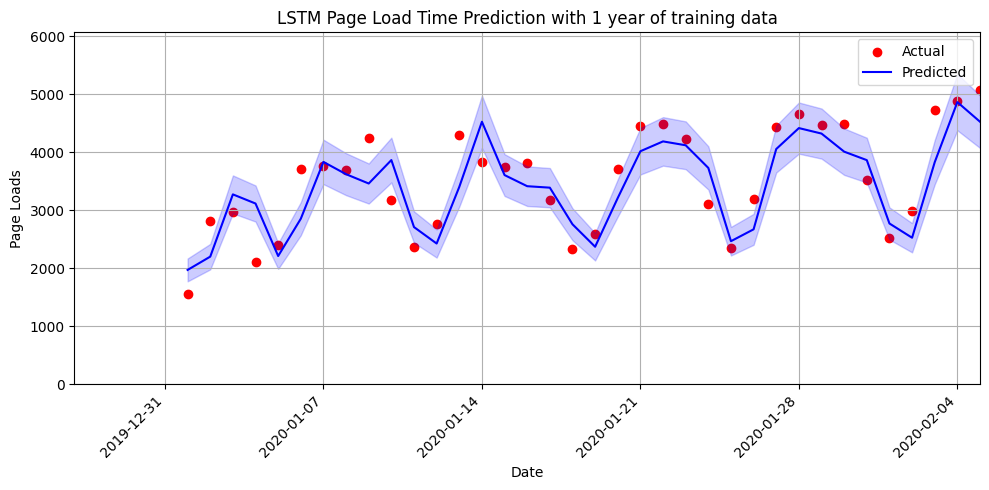

Predictions start on: 2020-01-01
Predictions end on: 2020-01-31


In [60]:
# Define window_size globally if not already done
window_size = 5

# Training data range
training_start_date = '2019-01-01'
training_end_date = '2019-12-26'
date_time = '1 year';

# Testing data range (needs to start from 5 days before to create the first prediction input)
testing_start_date = '2019-12-27'  # To include data for sequence creation starting from 2020-01-01
testing_end_date = '2020-02-05' # Extend to February 4th to predict January 31st

# Prepare training data
X_train, y_train = prepare_data(data, training_start_date, training_end_date, window_size, scaler)

# Train the model
model = train_model(X_train, y_train, window_size)

# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc[testing_start_date:testing_end_date, 'Page.Loads'][window_size:]

# Plot predictions against actual values
plot_predictions(data, y_test_actual.values, predicted_test, testing_start_date, testing_end_date, window_size, date_time)

# The start date of the predictions will be window_size days after the testing_start_date
prediction_start_date = pd.to_datetime(testing_start_date) + pd.DateOffset(days=window_size)
# The end date will be the same offset applied to the testing_end_date
prediction_end_date = pd.to_datetime(testing_end_date) - pd.DateOffset(days=window_size)

# Print out the start and end dates of your predictions
print(f"Predictions start on: {prediction_start_date.strftime('%Y-%m-%d')}")
print(f"Predictions end on: {prediction_end_date.strftime('%Y-%m-%d')}")

In [61]:
# Ensure the actual values and predictions are correctly aligned
# Since predictions are shifted due to the window size, you'll need to ensure that y_test_actual and predicted_test are the same length
y_test_actual = y_test_actual[:len(predicted_test)]  # This adjusts in case the lengths are off

# Calculate MSE
mse = mean_squared_error(y_test_actual, predicted_test)
print(f"Mean Squared Error (MSE):", np.sqrt(mse))

# Calculate MAE
mae = mean_absolute_error(y_test_actual, predicted_test)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(y_test_actual, predicted_test)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Squared Error (MSE): 490.26238758557633
Mean Absolute Error (MAE): 417.9516330295139
Mean Absolute Percentage Error (MAPE): 30.142104570121464%


## 2 YEARS OF TRAINING DATA

Epoch 1/50


c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4007
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2923 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2087 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1228 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0659 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0578 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0528 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0533 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0503 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0568 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0498 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0475 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0472 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0480 
Epoch 16/50
12/1

c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


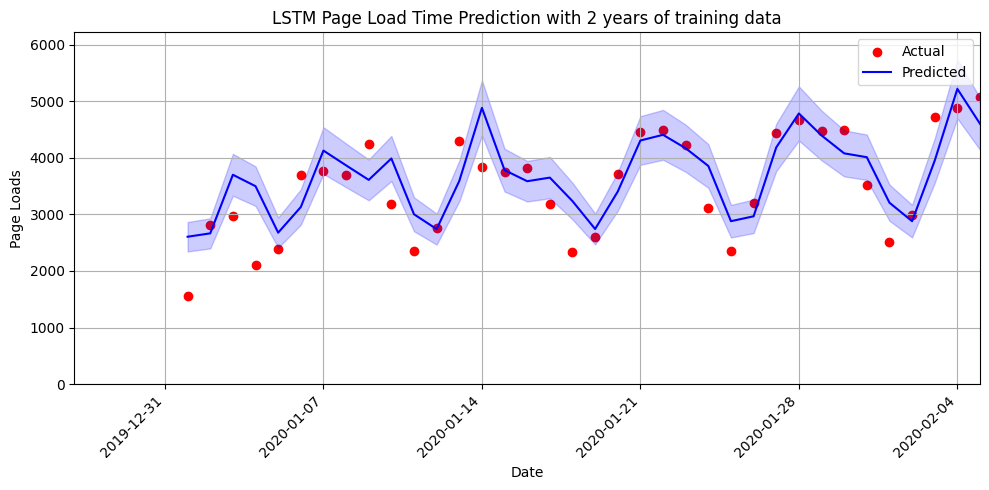

Predictions start on: 2020-01-01
Predictions end on: 2020-01-31


In [62]:
# Define window_size globally if not already done
window_size = 5

# Training data range
training_start_date = '2018-01-01'
training_end_date = '2018-12-26'
date_time = '2 years';
# Testing data range (needs to start from 5 days before to create the first prediction input)
testing_start_date = '2019-12-27'  # To include data for sequence creation starting from 2020-01-01
testing_end_date = '2020-02-05' # Extend to February 4th to predict January 31st

# Prepare training data
X_train, y_train = prepare_data(data, training_start_date, training_end_date, window_size, scaler)

# Train the model
model = train_model(X_train, y_train, window_size)

# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc[testing_start_date:testing_end_date, 'Page.Loads'][window_size:]

# Plot predictions against actual values
plot_predictions(data, y_test_actual.values, predicted_test, testing_start_date, testing_end_date, window_size, date_time)

# The start date of the predictions will be window_size days after the testing_start_date
prediction_start_date = pd.to_datetime(testing_start_date) + pd.DateOffset(days=window_size)
# The end date will be the same offset applied to the testing_end_date
prediction_end_date = pd.to_datetime(testing_end_date) - pd.DateOffset(days=window_size)

# Print out the start and end dates of your predictions
print(f"Predictions start on: {prediction_start_date.strftime('%Y-%m-%d')}")
print(f"Predictions end on: {prediction_end_date.strftime('%Y-%m-%d')}")

In [63]:
# Ensure the actual values and predictions are correctly aligned
# Since predictions are shifted due to the window size, you'll need to ensure that y_test_actual and predicted_test are the same length
y_test_actual = y_test_actual[:len(predicted_test)]  # This adjusts in case the lengths are off

# Calculate MSE
mse = mean_squared_error(y_test_actual, predicted_test)
print(f"Mean Squared Error (MSE):", np.sqrt(mse))

# Calculate MAE
mae = mean_absolute_error(y_test_actual, predicted_test)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(y_test_actual, predicted_test)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Squared Error (MSE): 559.0652856802026
Mean Absolute Error (MAE): 449.354254828559
Mean Absolute Percentage Error (MAPE): 30.519790191093964%


## 3 YEARS OF DATA


Epoch 1/50


c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1407
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0994 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0568 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0329 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0328 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0336 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0315
Epoch 16/50
12/12

c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


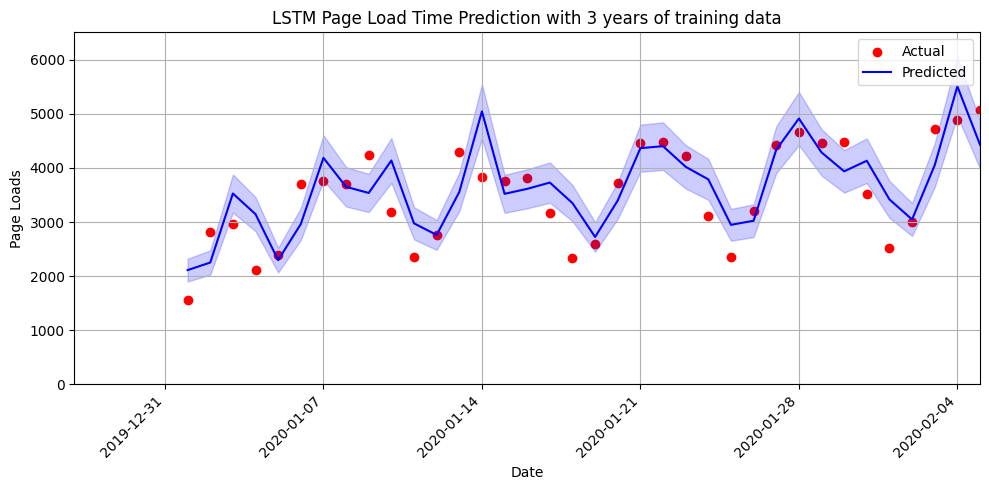

Predictions start on: 2020-01-01
Predictions end on: 2020-01-31


In [64]:
# Define window_size globally if not already done
window_size = 5

# Training data range
training_start_date = '2017-01-01'
training_end_date = '2017-12-26'
date_time = '3 years';
# Testing data range (needs to start from 5 days before to create the first prediction input)
testing_start_date = '2019-12-27'  # To include data for sequence creation starting from 2020-01-01
testing_end_date = '2020-02-05' # Extend to February 4th to predict January 31st

# Prepare training data
X_train, y_train = prepare_data(data, training_start_date, training_end_date, window_size, scaler)

# Train the model
model = train_model(X_train, y_train, window_size)

# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc[testing_start_date:testing_end_date, 'Page.Loads'][window_size:]

# Plot predictions against actual values
plot_predictions(data, y_test_actual.values, predicted_test, testing_start_date, testing_end_date, window_size, date_time)

# The start date of the predictions will be window_size days after the testing_start_date
prediction_start_date = pd.to_datetime(testing_start_date) + pd.DateOffset(days=window_size)
# The end date will be the same offset applied to the testing_end_date
prediction_end_date = pd.to_datetime(testing_end_date) - pd.DateOffset(days=window_size)

# Print out the start and end dates of your predictions
print(f"Predictions start on: {prediction_start_date.strftime('%Y-%m-%d')}")
print(f"Predictions end on: {prediction_end_date.strftime('%Y-%m-%d')}")

In [65]:
# Ensure the actual values and predictions are correctly aligned
# Since predictions are shifted due to the window size, you'll need to ensure that y_test_actual and predicted_test are the same length
y_test_actual = y_test_actual[:len(predicted_test)]  # This adjusts in case the lengths are off

# Calculate MSE
mse = mean_squared_error(y_test_actual, predicted_test)
print(f"Mean Squared Error (MSE):", np.sqrt(mse))

# Calculate MAE
mae = mean_absolute_error(y_test_actual, predicted_test)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(y_test_actual, predicted_test)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Squared Error (MSE): 574.3276133012344
Mean Absolute Error (MAE): 475.53557671440973
Mean Absolute Percentage Error (MAPE): 31.440394258000204%


## 4 YEARS OF DATA

Epoch 1/50


c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3754
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2726 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1833 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1000 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0584 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0636 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0524 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0493 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0567 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0467 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0472 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0454 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0469 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0444 
Epoch 16/50
12/1

c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


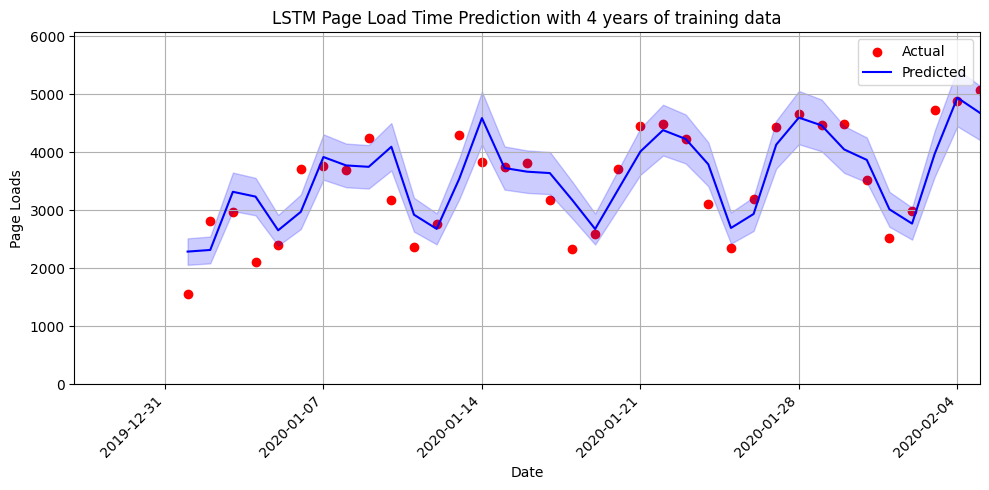

Predictions start on: 2020-01-01
Predictions end on: 2020-01-31


In [66]:
# Define window_size globally if not already done
window_size = 5

# Training data range
training_start_date = '2016-01-01'
training_end_date = '2016-12-26'
date_time = '4 years';
# Testing data range (needs to start from 5 days before to create the first prediction input)
testing_start_date = '2019-12-27'  # To include data for sequence creation starting from 2020-01-01
testing_end_date = '2020-02-05' # Extend to February 4th to predict January 31st

# Prepare training data
X_train, y_train = prepare_data(data, training_start_date, training_end_date, window_size, scaler)

# Train the model
model = train_model(X_train, y_train, window_size)

# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc[testing_start_date:testing_end_date, 'Page.Loads'][window_size:]

# Plot predictions against actual values
plot_predictions(data, y_test_actual.values, predicted_test, testing_start_date, testing_end_date, window_size, date_time)

# The start date of the predictions will be window_size days after the testing_start_date
prediction_start_date = pd.to_datetime(testing_start_date) + pd.DateOffset(days=window_size)
# The end date will be the same offset applied to the testing_end_date
prediction_end_date = pd.to_datetime(testing_end_date) - pd.DateOffset(days=window_size)

# Print out the start and end dates of your predictions
print(f"Predictions start on: {prediction_start_date.strftime('%Y-%m-%d')}")
print(f"Predictions end on: {prediction_end_date.strftime('%Y-%m-%d')}")

In [67]:
# Ensure the actual values and predictions are correctly aligned
# Since predictions are shifted due to the window size, you'll need to ensure that y_test_actual and predicted_test are the same length
y_test_actual = y_test_actual[:len(predicted_test)]  # This adjusts in case the lengths are off

# Calculate MSE
mse = mean_squared_error(y_test_actual, predicted_test)
print(f"Mean Squared Error (MSE):", np.sqrt(mse))

# Calculate MAE
mae = mean_absolute_error(y_test_actual, predicted_test)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(y_test_actual, predicted_test)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Squared Error (MSE): 492.25596719875097
Mean Absolute Error (MAE): 398.3743150499132
Mean Absolute Percentage Error (MAPE): 30.07956709717352%


## Making prediction using 2019 data using window_size 1

In [68]:
# Define window_size globally if not already done
window_size = 1

# Training data range
training_start_date = '2019-01-01'
training_end_date = '2019-12-30'

# Testing data range (needs to start from 5 days before to create the first prediction input)
testing_start_date = '2019-12-31'  # To include data for sequence creation starting from 2020-01-01
testing_end_date = '2020-02-01' # Extend to February 1th to predict January 31st

# Prepare training data
X_train, y_train = prepare_data(data, training_start_date, training_end_date, window_size, scaler)

# Train the model
model = train_model(X_train, y_train, window_size)

# Prepare testing data
X_test, y_test = prepare_data(data, testing_start_date, testing_end_date, window_size, scaler)

# Predict on test data
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

# Correctly get the actual values for the test period
y_test_actual = data.loc[testing_start_date:testing_end_date, 'Page.Loads'][window_size:]

# Plot predictions against actual values
plot_predictions(data, y_test_actual.values, predicted_test, testing_start_date, testing_end_date, window_size)

# The start date of the predictions will be window_size days after the testing_start_date
prediction_start_date = pd.to_datetime(testing_start_date) + pd.DateOffset(days=window_size)
# The end date will be the same offset applied to the testing_end_date
prediction_end_date = pd.to_datetime(testing_end_date) - pd.DateOffset(days=window_size)

# Print out the start and end dates of your predictions
print(f"Predictions start on: {prediction_start_date.strftime('%Y-%m-%d')}")
print(f"Predictions end on: {prediction_end_date.strftime('%Y-%m-%d')}")


Epoch 1/50


c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3005
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2768 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2424 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2009 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1867 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1497 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1352 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0956 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0819 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0608 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0458 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0420 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0357 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0327 
Epoch 16/50
12/1

c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


TypeError: plot_predictions() missing 1 required positional argument: 'date_time'

In [ ]:
# Ensure the actual values and predictions are correctly aligned
# Since predictions are shifted due to the window size, you'll need to ensure that y_test_actual and predicted_test are the same length
y_test_actual = y_test_actual[:len(predicted_test)]  # This adjusts in case the lengths are off

# Calculate MSE
mse = mean_squared_error(y_test_actual, predicted_test)
print(f"Mean Squared Error (MSE):", np.sqrt(mse))

# Calculate MAE
mae = mean_absolute_error(y_test_actual, predicted_test)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(y_test_actual, predicted_test)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Squared Error (MSE): 779.0070987351392
Mean Absolute Error (MAE): 626.2747039794922
Mean Absolute Percentage Error (MAPE): 30.616672956248998%
